In [2]:
using PhotonPropagation
using StaticArrays
using PhysicsTools
using CairoMakie
using CSV
using Format
using DataFrames
using Base.Iterators
using LinearAlgebra
buffer_cpu, buffer_gpu = make_hit_buffers();

## Axicone Simulation Study
Here we are comparing the ability to reconstruct the mean scattering angle with an Axicone and an LED.

In [3]:
spectrum = Monochromatic(488f0)
axi = AxiconeEmitter(SA_F32[0,0,0], SA_F32[0, 0, 1], 0f0, Int64(1E11), deg2rad(45f0), deg2rad(0.5f0))
led = CollimatedIsotropicEmitter(SA_F32[0,0,0], 0f0, Int64(1E11), cos(deg2rad(60f0)))
detector = [POM(SA_F32[0f0, 0f0, Float32(zpos)], i) for (i, zpos) in enumerate([-150, -100, -50, 50, 100, 150])]
detector = vcat(detector, [POM(SA_F32[0f0, 50f0, Float32(zpos)], i+length(detector)) for (i, zpos) in enumerate([-150, -100, -50, 0, 50, 100, 150])]);

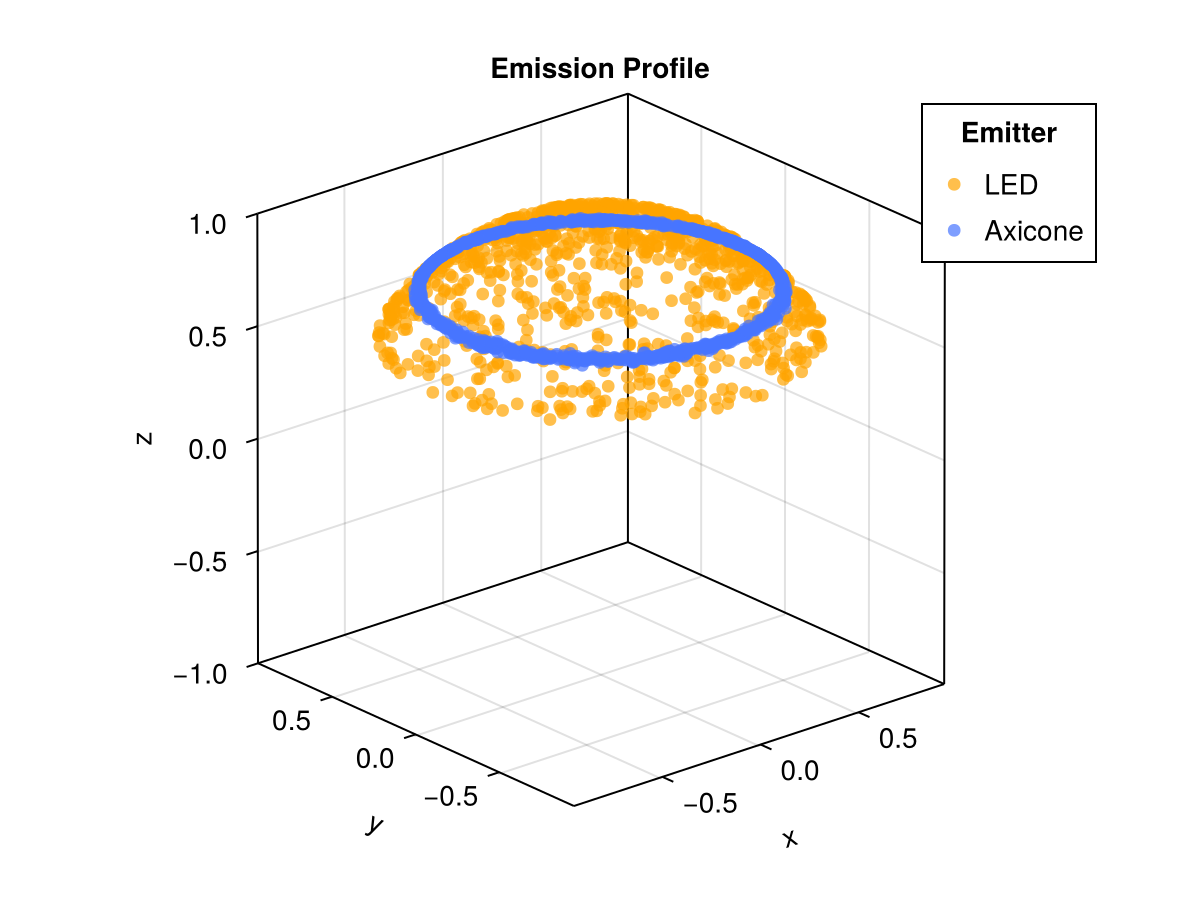

In [4]:
medium = make_cascadia_medium_properties(Float32(0.99), 1f0, 1f0)
initial_states_axicone = [PhotonPropagationCuda.initialize_photon_state(axi, medium, spectrum) for _ in 1:1000]
initial_states_led = [PhotonPropagationCuda.initialize_photon_state(led, medium, spectrum) for _ in 1:1000]
fig = Figure()
ax = Axis3(fig[1,1], aspect=(1,1,1), title="Emission Profile")
scatter!(ax, [state.direction for state in initial_states_led], color=(:orange, 0.7), label="LED")
scatter!(ax, [state.direction for state in initial_states_axicone], color=(:royalblue1, 0.7), label="Axicone")
zlims!(ax, -1, 1)
axislegend("Emitter")
fig

In [5]:
gs = [0.9, 0.93, 0.95, 0.99]
emitters = [:axicone, :led]
hit_stats = []
seed = 1
for (g, emitter) in product(gs, emitters)
    medium = make_cascadia_medium_properties(Float32(g), 1f0, 1f0)

    source = emitter == :axicone ? axi : led

    setup = PhotonPropSetup([source], detector, medium, spectrum, seed, 1.)
    photons = propagate_photons(setup, buffer_cpu, buffer_gpu, copy_output=true)
    hits = make_hits_from_photons(photons, setup)
    calc_pe_weight!(hits, setup)
    hits[!, :g] .= g
    hits[!, :emitter] .= emitter
    hits[!, :line_id] .= hits[:, :module_id] .< 7
    push!(hit_stats, hits)
end
hit_stats = reduce(vcat, hit_stats)
;

In [6]:
sca_lens = 0.9:0.05:1.1
emitters = [:axicone, :led]
hit_stats_sca = []
seed = 1
for (sca_len, emitter) in product(sca_lens, emitters)
    medium = make_cascadia_medium_properties(Float32(0.95), 1f0, Float32(sca_len))

    source = emitter == :axicone ? axi : led

    setup = PhotonPropSetup([source], detector, medium, spectrum, seed, 1.)
    photons = propagate_photons(setup, buffer_cpu, buffer_gpu, copy_output=true)
    hits = make_hits_from_photons(photons, setup)
    calc_pe_weight!(hits, setup)
    hits[!, :sca_len] .= sca_len
    hits[!, :emitter] .= emitter
    hits[!, :line_id] .= hits[:, :module_id] .< 7
    push!(hit_stats_sca, hits)
end
hit_stats_sca = reduce(vcat, hit_stats_sca);

In [ ]:
fig = Figure(size=(800, 800))
for (i, (emitter_name, em_group)) in enumerate(pairs(groupby(hit_stats, :emitter)))
    for (j, (line_id, line_group)) in enumerate(pairs(groupby(em_group, :line_id)))
        ax = Axis(fig[i, j], yscale=log10, xlabel="Z-Positions (m)", ylabel="Received Fraction", title="$(emitter_name[1]), line $(Int64(line_id[1]))")
        for (groupn, group) in pairs(groupby(line_group, :g))
            zpos_dict = Dict(mod.module_id => mod.shape.position[3] for mod in detector )
            total_hits = combine(groupby(group, :module_id), :total_weight => sum)

            total_hits = total_hits
            sort!(total_hits, :module_id)
            distances = [zpos_dict[mid] for mid in total_hits.module_id]
            lines!(ax, distances, total_hits.total_weight_sum ./ axi.photons, label=format("g: {:.2f}", groupn[1]))

        end
    end
end

linkaxes!([a for a in fig.content if a isa Axis]...)


Legend(fig[1, 3], fig.content[1], "Mean Scattering Angle")
fig

In [ ]:
fig = Figure(size=(800, 800))
for (i, (emitter_name, em_group)) in enumerate(pairs(groupby(hit_stats_sca, :emitter)))
    for (j, (line_id, line_group)) in enumerate(pairs(groupby(em_group, :line_id)))
        ax = Axis(fig[j, i], yscale=log10, xlabel="Z-Positions (m)", ylabel="Received Fraction", title="$(emitter_name[1]), line $(Int64(line_id[1]))")
        for (groupn, group) in pairs(groupby(line_group, :sca_len))
            zpos_dict = Dict(mod.module_id => mod.shape.position[3] for mod in detector )
            total_hits = combine(groupby(group, :module_id), :total_weight => sum)

            total_hits = total_hits
            sort!(total_hits, :module_id)
            distances = [zpos_dict[mid] for mid in total_hits.module_id]


            lines!(ax, distances, total_hits.total_weight_sum ./ axi.photons, label=format("sca_len: {:.2f}", groupn[1]))

        end
    end
end
fig